In [1]:
import scipy
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial import Delaunay

/home/cheer/.pyenv/versions/3.10.9/envs/amd_torch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


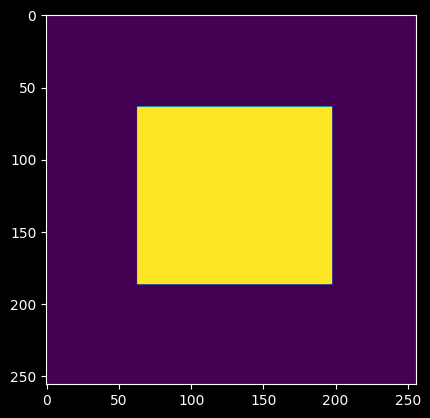

In [2]:

from utils import read_image, move_pixels_numpy, create_rect_mesh
from net import ConformalNet, check_inside_unit_disk, move_pixels_inverse_torch
from bc import diff_operator, bc_metric

img = read_image('img/rect.png', gray=True, binary_threshold=127, noramlize=True, CHW=True)
C, H, W = img.shape
img = torch.from_numpy(img).reshape(1, C, H, W).float()
mat = scipy.io.loadmat('matlab.mat')
f_map = torch.from_numpy(mat['map'])
f_map = f_map.reshape(W, H, 2).transpose(0,1)

# vy, vx = torch.meshgrid(torch.arange(H), torch.arange(W))
# vertex = torch.stack([vx, vy], dim=-1).double()

# tri = Delaunay(vertex.reshape(-1,2))
# face = torch.from_numpy(tri.simplices)
face, vertex = create_rect_mesh(H, W)


f_map_rescale = (f_map * min(H,W) + 2*torch.DoubleTensor([W,H]).reshape(1,1,2)) /4

plt.imshow(img[0,0])

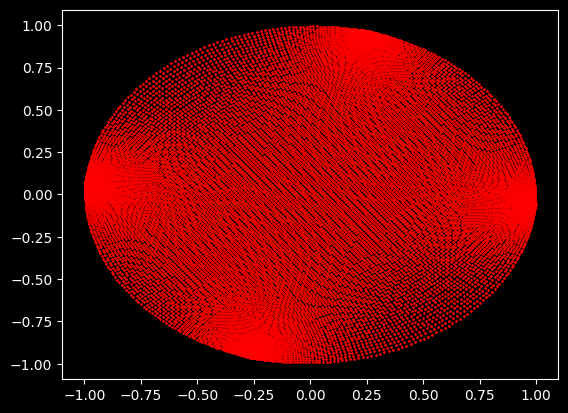

In [19]:
plt.scatter(f_map[:,:,0], f_map[:,:,1], s=1, c='r')

(tensor(4.9289e-05, dtype=torch.float64), tensor(1.0000, dtype=torch.float64))

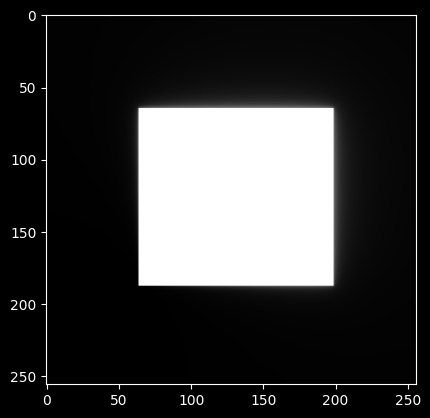

In [39]:
def check_inside_unit_disk(vertex: torch.Tensor, k=1e9):
    '''
    INPUT:
        vertex: N x H x W x 2 tensor
            original cordination of each pixel
    OUTPUT:
        result: N X H x W tensor
            whether the pixel is inside the unit circle
    '''
    # return torch.tanh((1 - torch.norm(vertex, 2, 3))*k) / 2 + 0.5
    return torch.sigmoid((1 - torch.norm(vertex, 2, 3))*k)

K = check_inside_unit_disk(f_map.reshape(1,H,W,2), 1e8).reshape(H,W)
plt.imshow(K, cmap='gray')
K.min(), K.max()

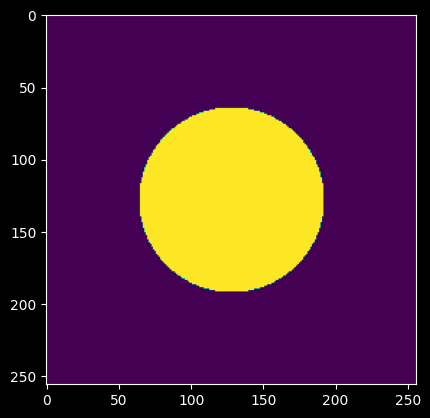

In [4]:
unit_disk_points = (vertex * 4 - 2 * torch.DoubleTensor([W, H]).reshape(1,1,2)) / min(H,W)
unit_disk = check_inside_unit_disk(unit_disk_points.reshape(1,H,W,2)).reshape(H,W)
plt.imshow(unit_disk)

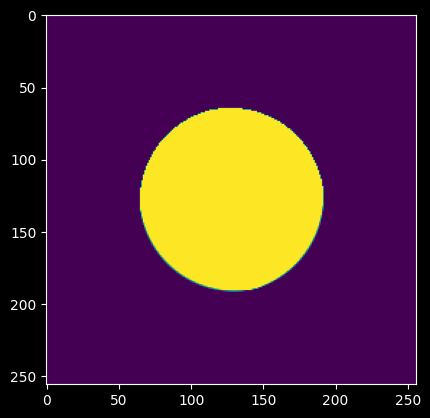

In [5]:
img_circle = move_pixels_numpy(img[0,0].numpy(), f_map_rescale.numpy(), vertex.numpy())
plt.imshow(img_circle)

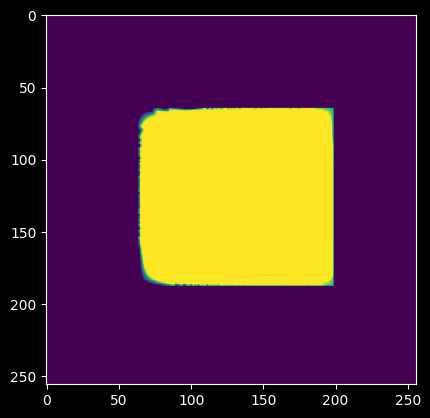

In [6]:
# plt.imshow(img_m[0,0])
# img_circle_torch = torch.tensor(img_circle.reshape(1,1,*img.shape))
img_circle_torch = unit_disk.reshape(1,1,H,W)
f_map_torch = f_map_rescale.reshape(1, H, W, 2)

img_inverse = move_pixels_inverse_torch(img_circle_torch, f_map_torch).reshape(H,W)
plt.imshow(img_inverse)

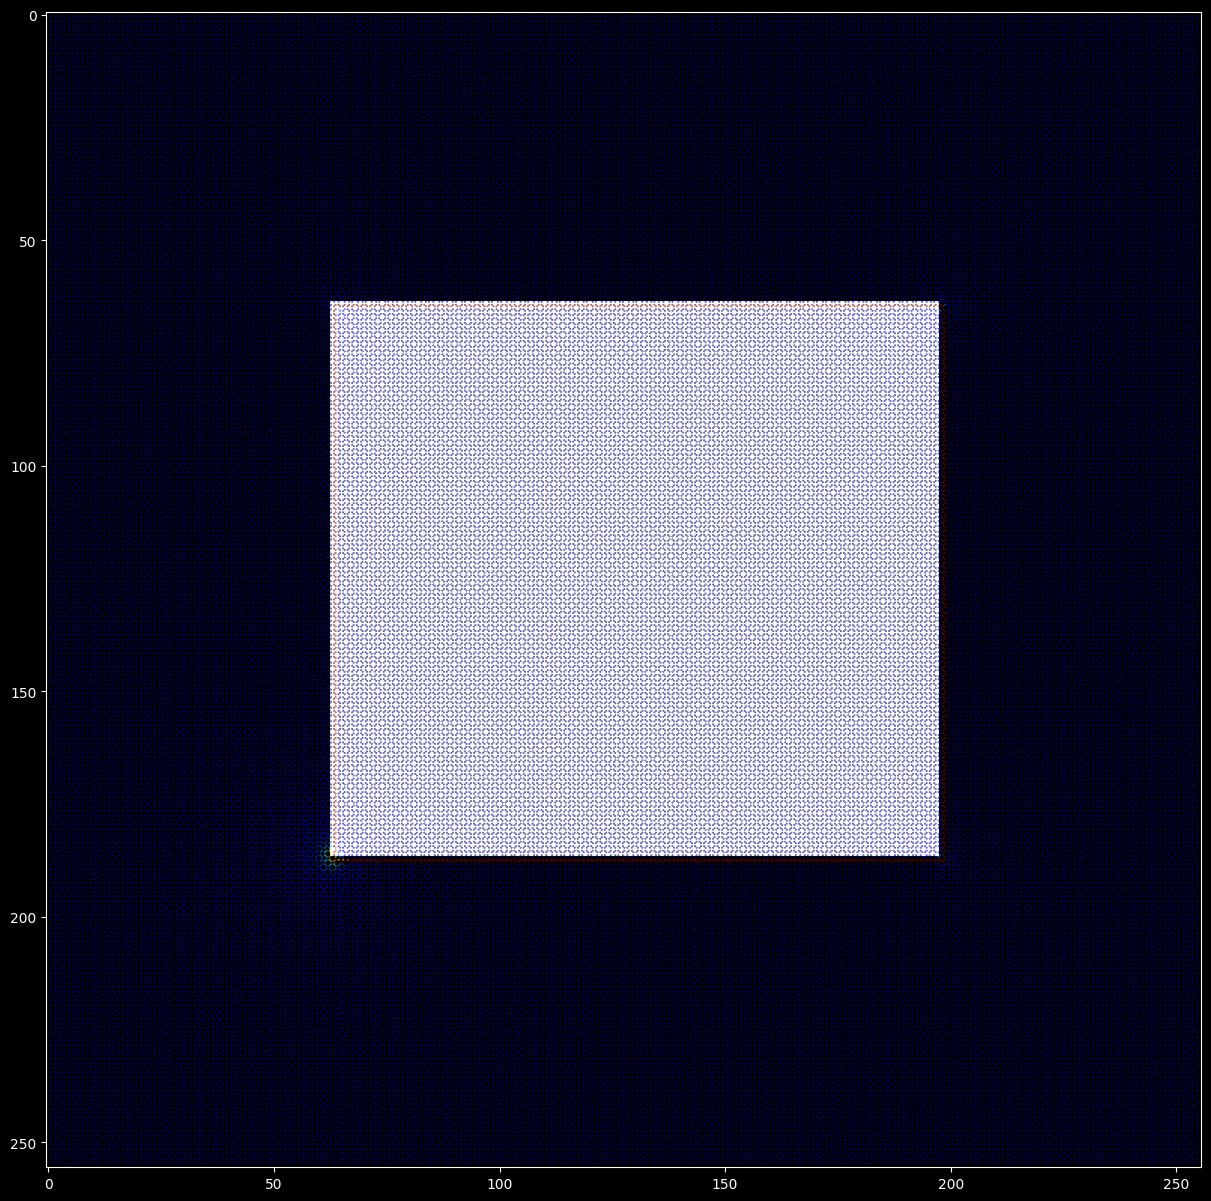

In [7]:
Dx, Dy = diff_operator(face, vertex.reshape(-1,2))
new_mu = bc_metric(f_map.reshape(1,H,W,2), Dx, Dy)
face_center = vertex.reshape(-1,2)[face[:,:], :].mean(1)
plt.figure(figsize=(15,15))
plt.imshow(img[0,0], cmap='gray')
plt.scatter(face_center[:,0], face_center[:, 1],s=0.1, c=new_mu[0].abs(), cmap='jet')

In [9]:
net = ConformalNet(H, W)
output = net(img)
loss = net.loss(output.double(), img)
loss

/home/cheer/.pyenv/versions/3.10.9/envs/amd_torch/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/cheer/.pyenv/versions/3.10.9/envs/amd_torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


tensor(459.2609, dtype=torch.float64, grad_fn=<AddBackward0>)